In [2]:

# 定义一个空列表来存储原子数据
atoms = [[], [], []]
file_names = ["water_273.trj", "water_300.trj", "water_400.trj"]

# 打开数据文件
for file_index, file_name in enumerate(file_names):
    with open(file_name, "r") as file:
        for line in file:
            # 去掉行尾的换行符
            line = line.strip()
            if "ITEM: TIMESTEP" in line:
                line=file.readline().strip()
                timestep=int(int(line)/1000)
                #print(timestep)
                atoms[file_index].append([])
                for i in range(7):
                    file.readline()
                # 读取一帧原子数据
                while True:
                    atom_line = file.readline().strip()
                    #print(atom_line)
                    atom_data = atom_line.split()
                    atom = {
                        "id": int(atom_data[0]),
                        "mol": int(atom_data[1]),
                        "xu": float(atom_data[2]),
                        "yu": float(atom_data[3]),
                        "zu": float(atom_data[4]),
                        "type": int(atom_data[5]),
                        "element": atom_data[6],
                    }
                    atoms[file_index][timestep].append(atom)
                    if atom["id"] == 4500:
                        break
                # 一旦读取完所有原子数据，就退出循环

# 打印原子数据
print(atoms[0][0][0])
#print(atoms[1][4513509-11])

{'id': 1, 'mol': 1, 'xu': 12.3783, 'yu': 64.0322, 'zu': 22.1537, 'type': 1, 'element': 'C'}


[0.3408888888888889, 0.41844444444444445, 0.2611111111111111, 1.0573333333333332, 1.3422222222222222, 2.0735555555555556, 2.8055555555555554, 3.6986666666666665, 4.573777777777778, 5.647555555555556, 6.602888888888889, 7.733777777777778, 8.906444444444444, 10.138, 11.252888888888888, 12.514666666666667, 13.834, 14.933111111111112, 15.971111111111112, 17.224888888888888, 18.229333333333333, 19.21, 20.112444444444446, 21.11288888888889, 21.846888888888888, 22.441777777777776, 23.090666666666667, 23.586, 24.040666666666667, 24.54088888888889, 24.68422222222222, 24.670444444444446, 24.698, 24.364444444444445, 24.03088888888889, 23.75488888888889, 23.298222222222222, 22.976666666666667, 22.239555555555555, 21.744444444444444, 21.173111111111112, 20.64911111111111, 19.962666666666667, 19.277555555555555, 18.535333333333334, 18.05377777777778, 17.313555555555556, 16.666666666666668, 15.794, 15.108888888888888, 14.37711111111111, 13.741777777777777, 13.09911111111111, 12.565777777777777, 11.83

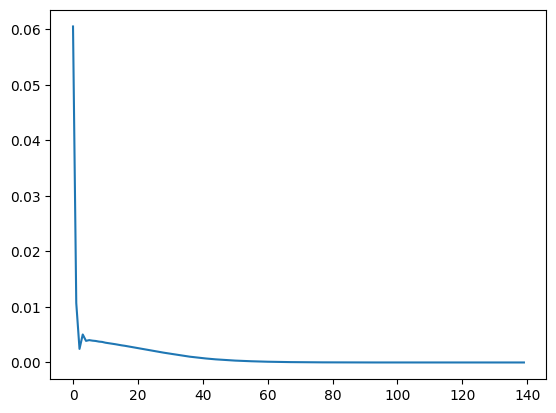

In [3]:
import math
import numpy as np
# atoms为指定温度
atoms_273=atoms[0]
atoms_300=atoms[1]
atoms_400=atoms[2]
def get_density_distribution(atoms_t,dr,sframe,eframe,mtype,stype):
    density_frame = []
    density=[]
    mnum=0
    bintotal=1000000#假设最大bin，进行初始化
    max_distance=0
    for i in range(0,bintotal+1):
        density.append(0)
        density_frame.append(0)
    for i in range(sframe,eframe+1):
        for j in range(0,4500):
            mnum+=1
            if atoms_t[i][j]["type"]==mtype:
                for k in range(0,4500):
                    if atoms_t[i][k]["type"]==stype:
                        distance = math.sqrt((atoms_t[i][j]["xu"]-atoms_t[i][k]["xu"])**2+(atoms_t[i][j]["yu"]-atoms_t[i][k]["yu"])**2+(atoms_t[i][j]["zu"]-atoms_t[i][k]["zu"])**2)
                        if distance==0:
                            continue
                        if distance>max_distance:
                            max_distance=distance
                        nbin=int(distance/dr)
                        density_frame[nbin]+=1
        bintotal = int(max_distance / dr)
        density_frame=[x/mnum for x in density_frame]
        print(density_frame[:100])
        for bin in range(0,bintotal):
            density_frame[bin]=density_frame[bin]/((4/3)*math.pi*dr*((bin+1)**3-bin**3))
            density[bin]+=density_frame[bin]
        density_frame[bintotal]=density_frame[bintotal]/((4/3)*math.pi*(max_distance**3-(dr*bintotal)**3))#最大距离占不满dr,特殊处理
        density[bintotal]+=density_frame[bintotal]
    density=[x/(eframe-sframe+1) for x in density]
    #print(density[0:100])
    return density,max_distance

import matplotlib.pyplot as plt
def pic_line_chart(L,max_dist,dr):
    nbin=int(max_dist/dr)
    x=[i*dr for i in range(0,nbin+1)]
    y=L[:nbin+1]
    plt.plot(x,y)
    plt.savefig("density_distribution.png")

#task1求解
dr=1
density,max_dist=get_density_distribution(atoms_400,dr,0,1,1,2)
density=list(density)
pic_line_chart(density,max_dist,dr)
    

In [4]:
def get_hb_distribution(atoms_t,sframe,eframe):#计算氢键分布,若仅使用一帧，sframe=eframe
    hbmax=3.5
    hb=[]
    for i in range(sframe,eframe+1):
        for j in range(0,4500):
            if atoms_t[i][j]["type"]==1:
                for k in range(0,4500):
                    if atoms_t[i][k]["type"]==2 and atoms_t[i][j]["mol"]!=atoms_t[i][k]["mol"]:
                        rhb= math.sqrt((atoms_t[i][j]["xu"]-atoms_t[i][k]["xu"])**2+(atoms_t[i][j]["yu"]-atoms_t[i][k]["yu"])**2+(atoms_t[i][j]["zu"]-atoms_t[i][k]["zu"])**2)

                        if rhb <hbmax:
                            oid = atoms_t[i][j]["id"]-1#索引比id小1
                            hid= atoms_t[i][k]["id"]-1
                            if (hid+1)%3==0:
                                h_oid=hid-2
                            else:
                                h_oid=hid-1
                            o_hid1=oid+1
                            o_hid2=oid+2
                            #print("hid",hid,"oid",oid,"h_oid",h_oid,"o_hid1",o_hid1,"o_hid2",o_hid2)
                            h_roh=math.sqrt((atoms_t[i][h_oid]["xu"]-atoms_t[i][hid]["xu"])**2+(atoms_t[i][h_oid]["yu"]-atoms_t[i][hid]["yu"])**2+(atoms_t[i][h_oid]["zu"]-atoms_t[i][hid]["zu"])**2)
                            roo=math.sqrt((atoms_t[i][oid]["xu"]-atoms_t[i][h_oid]["xu"])**2+(atoms_t[i][oid]["yu"]-atoms_t[i][h_oid]["yu"])**2+(atoms_t[i][oid]["zu"]-atoms_t[i][h_oid]["zu"])**2)
                            oho=(h_roh**2+rhb**2-roo**2)/(2*h_roh*rhb)
                            rhh1=math.sqrt((atoms_t[i][hid]["xu"]-atoms_t[i][o_hid1]["xu"])**2+(atoms_t[i][hid]["yu"]-atoms_t[i][o_hid1]["yu"])**2+(atoms_t[i][hid]["zu"]-atoms_t[i][o_hid1]["zu"])**2)
                            rhh2=math.sqrt((atoms_t[i][hid]["xu"]-atoms_t[i][o_hid2]["xu"])**2+(atoms_t[i][hid]["yu"]-atoms_t[i][o_hid2]["yu"])**2+(atoms_t[i][hid]["zu"]-atoms_t[i][o_hid2]["zu"])**2)
                            o_roh1=math.sqrt((atoms_t[i][oid]["xu"]-atoms_t[i][o_hid1]["xu"])**2+(atoms_t[i][oid]["yu"]-atoms_t[i][o_hid1]["yu"])**2+(atoms_t[i][oid]["zu"]-atoms_t[i][o_hid1]["zu"])**2)
                            o_roh2=math.sqrt((atoms_t[i][oid]["xu"]-atoms_t[i][o_hid2]["xu"])**2+(atoms_t[i][oid]["yu"]-atoms_t[i][o_hid2]["yu"])**2+(atoms_t[i][oid]["zu"]-atoms_t[i][o_hid2]["zu"])**2)
                            hoh1=(rhb**2+o_roh1**2-rhh1**2)/(2*rhb*o_roh1)#取O接下来一个H计算
                            hoh2=(rhb**2+o_roh2**2-rhh2**2)/(2*rhb*o_roh2)#取O接下下一个H计算
                            #print("oho",oho,"hoh1",hoh1,"hoh2",hoh2,"rhb",rhb)
                            hb.append(
                                {
                                    "j,k": (j,k),
                                    "omol": atoms_t[i][j]["mol"],
                                    "hmol": atoms_t[i][k]["mol"],
                                    "rhb": rhb,
                                    "oho": math.acos(oho),  # rad制
                                    "hoh": (math.acos(hoh1) + math.acos(hoh2)) / 2,
                                }
                            )
    sum_oho=0
    sum_hoh=0
    sum_rhb=0
    for i in hb:
        sum_oho+=i["oho"]
        sum_hoh+=i["hoh"]
        sum_rhb+=i["rhb"]
    avg_oho=sum_oho/len(hb)
    avg_hoh=sum_hoh/len(hb)
    avg_rhb=sum_rhb/len(hb)
    return avg_oho,avg_hoh,avg_rhb,hb

avg_oho,avg_hoh,avg_rhb,hb=get_hb_distribution(atoms_400,0,1)  
print(avg_oho,avg_hoh,avg_rhb)
#print(hb[0:10])

1.7293865389201435 1.6047162795258758 2.922506035779611


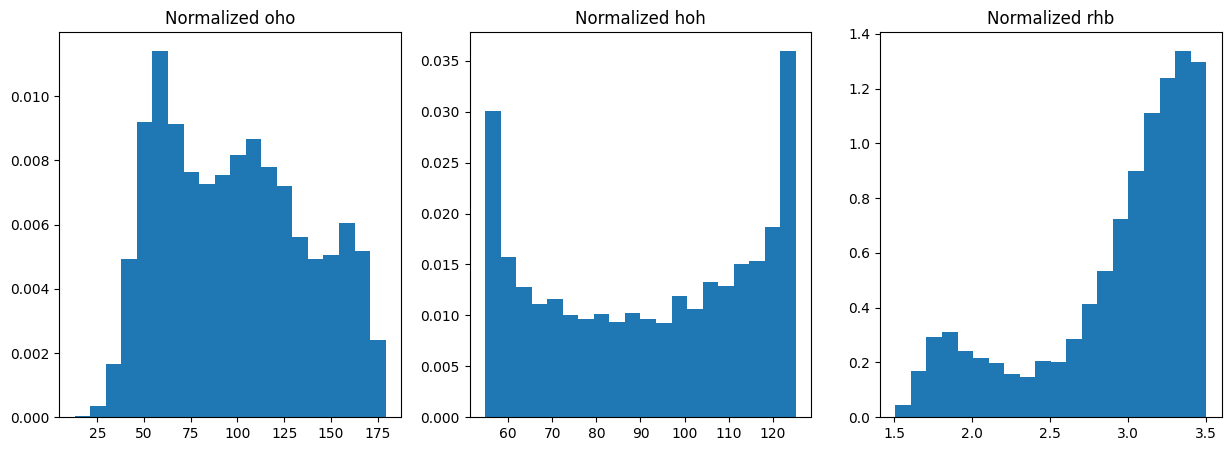

In [5]:

def hb_get_histogram(hb):
    times=0
    oho = []
    hoh = []
    rhb = []
    for i in hb:
        oho.append(i["oho"]*180/math.pi)
        hoh.append(i["hoh"]*180/math.pi)
        rhb.append(i["rhb"])
        times+=1
    
    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the histograms on the subplots
    axs[0].hist(oho, bins=20,density=True)
    axs[0].set_title("Normalized oho")

    axs[1].hist(hoh, bins=20,density=True)
    axs[1].set_title("Normalized hoh")

    axs[2].hist(rhb, bins=20,density=True)
    axs[2].set_title("Normalized rhb")

    # Display the plot
    plt.savefig("histograms.png")


hb_get_histogram(hb)

In [6]:
def get_intervals(avg_hoh,avg_oho,avg_rhb,hb):
    oho = []
    hoh = []
    rhb = []
    for i in hb:
        oho.append(i["oho"])
        hoh.append(i["hoh"])
        rhb.append(i["rhb"])
    min_oho = min(oho)
    max_oho = max(oho)
    delta_oho = max(max_oho - avg_oho, avg_oho - min_oho)
    min_hoh = min(hoh)
    max_hoh = max(hoh)
    delta_hoh = max(max_hoh - avg_hoh, avg_hoh - min_hoh)
    avg_oho=avg_oho*180/math.pi
    delta_oho=delta_oho*180/math.pi
    avg_hoh=avg_hoh*180/math.pi
    delta_hoh=delta_hoh*180/math.pi
    min_rhb = min(rhb)
    max_rhb = max(rhb)
    delta_rhb = max(max_rhb - avg_rhb, avg_rhb - min_rhb)
    print(avg_oho,"+-",delta_oho,";",avg_hoh,"+-",delta_hoh,";",avg_rhb,"+-",delta_rhb)
    return delta_oho,delta_hoh,delta_rhb
get_intervals(avg_hoh,avg_oho,avg_rhb,hb)

99.08654982686109 +- 86.19234831998803 ; 91.94347013276837 +- 37.21095091814885 ; 2.922506035779611 +- 1.4165441854991998


(86.19234831998803, 37.21095091814885, 1.4165441854991998)

In [13]:
# edges=edges[0:100]


def DFS(vertex, graph, visited, component):
    visited[vertex] = True
    component.append(vertex)
    for neighbor in graph[vertex]:
        if not visited[neighbor]:
            DFS(neighbor, graph, visited, component)


def connectedComponents(hb):

    edges = [(hb[0]["omol"], hb[0]["hmol"])]
    for linkhb in hb:
        a = (linkhb["omol"], linkhb["hmol"])
        if a == edges[-1]:  # 去除相同两个水分子间重复的氢键
            continue
        edges.append(a)
    graph = {}
    for edge in edges:
        a, b = edge
        if a not in graph:
            graph[a] = []
        if b not in graph:
            graph[b] = []
        graph[a].append(b)
        graph[b].append(a)

    visited = {}
    for vertex in graph:
        visited[vertex] = False

    components = []
    for vertex in graph:
        if not visited[vertex]:
            component = []
            DFS(vertex, graph, visited, component)
            components.append(component)

    return components


def get_cluster_num(hb):
    clusters = connectedComponents(hb)
    cluster_2 = []
    cluster_3 = []
    cluster_4 = []
    cluster_5 = []
    cluster_6 = []
    for cluster in clusters:
        if len(cluster) == 2:
            cluster_2.append(cluster)
        elif len(cluster) == 3:
            cluster_3.append(cluster)
        elif len(cluster) == 4:
            cluster_4.append(cluster)
        elif len(cluster) == 5:
            cluster_5.append(cluster)
        elif len(cluster) == 6:
            cluster_6.append(cluster)

    clusernum = [len(cluster_2), len(cluster_3), len(cluster_4), len(cluster_5), len(cluster_6)]
    return clusernum


def pic_cluster_num(atoms_400):
    cluster_time = []
    for i in range(0, 1000):
        _, _, _, hb = get_hb_distribution(atoms_400, i, i)
        cluster_time.append(get_cluster_num(hb))
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))
    x=range(0,1000)
    y2=[y[0] for y in cluster_time]
    axs[0].plot(
        x, y2, "b*--", alpha=0.5, linewidth=1, label="cluster_2"
    )
    axs[0].set_title("cluster_2")
    y3=[y[1] for y in cluster_time]
    axs[1].plot(
        x, y3, "b*--", alpha=0.5, linewidth=1, label="cluster_3"
    )
    axs[1].set_title("cluster_3")
    y4=[y[2] for y in cluster_time]
    axs[2].plot(
        x, y4, "b*--", alpha=0.5, linewidth=1, label="cluster_4"
    )
    axs[2].set_title("cluster_4")
    y5=[y[3] for y in cluster_time]
    axs[3].plot(
        x, y5, "b*--", alpha=0.5, linewidth=1, label="cluster_5"
    )
    axs[3].set_title("cluster_5")
    y6=[y[4] for y in cluster_time]
    axs[4].plot(
        x, y6, "b*--", alpha=0.5, linewidth=1, label="cluster_6"
    )
    
    
    
    
    
    

[13, 4, 7, 2]
